In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import re
from time import time
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
import nltk
#nltk.download('punkt')

In [ ]:
#df = pd.read_excel('final_210623_nouveaux labels.xlsx',engine='openpyxl')
df = pd.read_excel('fin.xlsx',engine='openpyxl')
#= data[data["Messages"].notna()]
col=['Messages','catégorie']
df=df[col]
df=df.head(2800)
len(df)

In [ ]:
df['Messages']=df['Messages'].astype(str)

In [ ]:
print(df['Messages'].apply(lambda x: len(x.split(' '))).sum())

In [ ]:
df.isnull().sum()

In [ ]:
#df.loc[df['catégorie'].isin(['renseignement facture','demande de renseignement']),'catégorie'] = 'renseignement'

In [ ]:
df.catégorie.value_counts()

In [ ]:
df.replace({'catégorie': 
             {
              'renseignement facture': 'demande de renseignement,réclamation qualité de service,impayé,renseignement facture',
             'réclamation qualité de service': 'demande de renseignement,réclamation qualité de service,impayé,renseignement facture',
             'contrat': 'no message,contrat,interne Axxès',
              'demande de renseignement':'demande de renseignement,réclamation qualité de service,impayé,renseignement facture',
              'no message':'no message,contrat,interne Axxès',
              'interne Axxès':'no message,contrat,interne Axxès'
             # 'impayé,renseignement facture':'demande de renseignement,réclamation qualité de service,impayé,renseignement facture'
             }}, 
            inplace= True)

In [ ]:
df.catégorie.value_counts()

In [ ]:
from langdetect import detect

In [ ]:
texl70 = df['Messages']
langdet = []
    
for i in range(len(df)):                                         
    try:                                                          
        lang=detect(texl70[i])                                      
    except:                                                       
        lang=''                                                  
        print("This row throws error:", texl70[i])                 
    langdet.append(lang)  

In [ ]:
df['lang']=langdet

In [ ]:
df=df.loc[df['lang']=='fr']

In [ ]:
df

In [ ]:
df['occurence']=0
mots = ["cordialement", "best regards","bien à vous", "Bien cordialement","Cordialment","Restant à votre disposition",
       "Salutations","Bonne réception","Sincères salutations","Cdt","cdlt",
        "Bonne fin de journée","bonne réception"]
for mot in mots:
    for i in df.index:
        ss=df['Messages'][i].lower()
        if mot in ss:
            df['occurence'][i]=ss.find(mot.lower())

In [ ]:
for i in df.index:
    if df['occurence'][i]>0:
        df['Messages'][i]=df['Messages'][i][0:df['occurence'][i]]
    else:
        df['Messages'][i]=df['Messages'][i]

In [ ]:
from nltk.stem import WordNetLemmatizer
from unidecode import unidecode

lem = WordNetLemmatizer()
def cleanResume(resumeText):
    resumeText = resumeText.lower()
    resumeText = unidecode(resumeText)
    resumeText = re.sub('http\S+\s*', ' ', resumeText)  # remove URLs
    resumeText = re.sub('RT|cc', ' ', resumeText)  # remove RT and cc
    resumeText = re.sub('#\S+', '', resumeText)  # remove hashtags
    resumeText = re.sub('@\S+', '  ', resumeText)  # remove mentions
    resumeText = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', resumeText)  # remove punctuations
    resumeText = re.sub('([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)', 'XXXX',  resumeText)#email
    #phone
    resumeText = re.sub(r"/\d{10}|\+33\d{9}|\+33\s\d{1}\s\d{2}\s\d{2}\s\d{2}\s\d{2}|\d{2}\s\d{2}\s\d{2}\s\d{2}\s\d{2}/g",' XXXX', resumeText)#phone francais
    resumeText = re.sub(r'(^(\+33 |0)[1-6]{1}(([0-9]{2}){4})|((\s[0-9]{2}){4})|((-[0-9]{2}){4})$)','XXXX', resumeText)
    resumeText = re.sub("((?:\+\d{2}[-\.\s]??|\d{4}[-\.\s]??)?(?:\d{3}[-\.\s]??\d{3}[-\.\s]??\d{4}|\(\d{3}\)\s*\d{3}[-\.\s]??\d{4}|\d{3}[-\.\s]??\d{4}))",'XXXX',  resumeText)#phone
    resumeText = re.sub('\(?\d{2}\)?[-.\s]?\d{2}[-.\s]?\d{2}[-.\s]?\d{2}[-.\s]?\d{2}','XXXX', resumeText)
    resumeText = re.sub('\(?\d{2}\)?[-.\s]?\d{2}[-.\s]?\d{2}[-.\s]?\d{2}[-.\s]','XXXX', resumeText)
    resumeText = re.sub('\(?\d{1}\)?[-.\s]?\d{2}[-.\s]?\d{2}[-.\s]?\d{2}[-.\s]','XXXX', resumeText)
    resumeText = re.sub('\(?\d{2}\)?[-.\s]?\d{5}[-.\s]?\d{3}','XXXX', resumeText)
    resumeText = re.sub('\(?\d{1}\)?[-.\s]?\d{2}[-.\s]?\d{2}[-.\s]?\d{3}','XXXX', resumeText)
    resumeText = re.sub('\(?\d{2}\)?[-.\s]?\d{3}[-.\s]?\d{3}[-.\s]?\d{3}','XXXX', resumeText)
    #Emoji
    emoji= re.compile(u'['u'\U0001F300-\U0001F64F'u'\U0001F680-\U0001F6FF'u'\u2600-\u26FF\u2700-\u27BF]+', re.UNICODE)
    resumeText = re.sub(emoji,' ', resumeText)
    #text
    resumeText =  resumeText.replace("Avant d\'imprimer cet e-mail, réfléchissez à l\'impact sur l\'environnementBefore you print this mail, think about the impact on the environment",'')
    dele = ["Mail:","Email:","e-mail","Email : ","mail","Tél : +","Fax : +","tél.: + ()","port.: + () ","fax.: + ()"]
    #df['Text'][i]= df['Text'][i].replace(dele,'')
    resumeText =  resumeText.replace("Mail:",' ')
    resumeText =  resumeText.replace("Email:",' ')
    resumeText =  resumeText.replace("E-mail",' ')
    resumeText =  resumeText.replace("Email : ",' ')
    resumeText=  resumeText.replace("mail",' ')
    resumeText=re.sub(r'\d{3}[-\.\s]??\d{3}[-\.\s]??\d{4}|\(\d{3}\)\s*\d{3}[-\.\s]??\d{4}|\d{3}[-\.\s]??\d{4}','XXXX', resumeText)
    #df['Text'][i]=re.sub(r'\d+','',str(df['Text'][i]))#Tél : +      Fax : +, tél.: + ()       fax.: + ()      port.: + () 
    resumeText = re.sub("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+",'XXXX', resumeText)#url
    resumeText = re.sub('(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})',' XXXX', resumeText)#url www
    resumeText = re.sub('Ce message et toutes les Pieces jointes (ci apres : le message) sont etablis a l\'intention exclusive de ses destinataires et sont confidentiels.Toute utilisation de ce message non conforme a sa destination, toute diffusion ou toute publication totale ou partielle est interdite sauf autorisation prealable.Si vous recevez ce message par erreur, merci de le detruire et d\' avertir immediatement l\'expediteur.Les communications sur Internet n\'etant pas securisees, le Groupe APRR decline toute responsabilite quant au contenu de ce message.This message and all attached documents (hereafter "the message") are intended for the exclusive attention of its recipients and are confidential. Any use of this message, for which it was not intended, any distribution or any total or partial publication is prohibited unless previously approved.If you receive this message in error, please destroy it and immediately notify the sender thereof.Since communication by Internet is not secure, Group APRR cannot accept any responsibility regarding the contents of this message.','XXXX ', resumeText)
    #df['Text'][i]= re.sub('SCAN <>Cet  a été envoyé par "copieurRICOH" (MP C3004ex).Date de numérisation: 07.08.2020 17:17:25 (+0200)Contacter si besoin :  ','',str(df['Text'][i]))
    resumeText = re.sub('Ce message est généré automatiquement. Merci de ne pas y répondre.','XXXX', resumeText)
    resumeText = re.sub('Ce message et toutes les Pieces jointes (ci apres : le message) sont etablis a l\'intention exclusive de ses destinataires et sont confidentiels.Toute utilisation de ce message non conforme a sa destination, toute diffusion ou toute publication totale ou partielle est interdite sauf autorisation prealable.Si vous recevez ce message par erreur, merci de le detruire et d\' avertir immediatement l\'expediteur.Les communications sur Internet n\'etant pas securisees, le Groupe APRR decline toute responsabilite quant au contenu de ce message.This message and all attached documents (hereafter "the message") are intended for the exclusive attention of its recipients and are confidential. Any use of this message, for which it was not intended, any distribution or any total or partial publication is prohibited unless previously approved.If you receive this message in error, please destroy it and immediately notify the sender thereof.Since communication by Internet is not secure, Group APRR cannot accept any responsibility regarding the contents of this message.','XXXX ', resumeText)
    resumeText = re.sub('This message and any attachments are confidential and intended for the named addressee(s) only.If you have received this message in error, please notify immediately the sender, then deletethe message. Any unauthorized modification, edition, use or dissemination is prohibited.The sender shall not be liable for this message if it has been modified, altered, falsified, infectedby a virus or even edited or disseminated without authorization.','XXXX', resumeText)
    resumeText = re.sub('This  transmission (message and any attached files) may contain information that is proprietary, privileged and/or confidential to Veolia Environnement and/or its affiliates and is intended exclusively for the person(s) to whom it is addressed. If you are not the intended recipient, please notify the sender by return  and delete all copies of this , including all attachments. Unless expressly authorized, any use, disclosure, publication, retransmission or dissemination of this  and/or of its attachments is strictly prohibited. Ce message electronique et ses fichiers attaches sont strictement confidentiels et peuvent contenir des elements dont Veolia Environnement et/ou l\'une de ses entites affiliees sont proprietaires. Ils sont donc destines a l\'usage de leurs seuls destinataires. Si vous avez recu ce message par erreur, merci de le retourner a son emetteur et de le detruire ainsi que toutes les pieces attachees. L\'utilisation, la divulgation, la publication, la distribution, ou la reproduction non expressement autorisees de ce message et de ses pieces attachees sont interdites.','XXXX ', resumeText)
    resumeText = re.sub('This  transmission (message and any attached files) may contain information that is proprietary, privileged and/or confidential to Veolia Environnement and/or its affiliates and is intended exclusively for the person(s) to whom it is addressed. If you are not the intended recipient, please notify the sender by return  and delete all copies of this , including all attachments. Unless expressly authorized, any use, disclosure, publication, retransmission or dissemination of this  and/or of its attachments is strictly prohibited.  Ce message electronique et ses fichiers attaches sont strictement confidentiels et peuvent contenir des elements dont Veolia Environnement et/ou l\'une de ses entites affiliees sont proprietaires. Ils sont donc destines a l\'usage de leurs seuls destinataires. Si vous avez recu ce message par erreur, merci de le retourner a son emetteur et de le detruire ainsi que toutes les pieces attachees. L\'utilisation, la divulgation, la publication, la distribution, ou la reproduction non expressement autorisees de ce message et de ses pieces attachees sont interdites.','XXXX ', resumeText)
    resumeText = re.sub('Le contenu de ce message est strictement réservé à l\'usage exclusif de son destinataire et contient de l\'information privilégiée et confidentielle. Toute lecture, divulgation, distribution ou copie non autorisée de cette communication est formellement interdite. Si vous avez reçu cette communication par erreur, veuillez la détruire immédiatement.','XXXX', resumeText)
    resumeText = re.sub('Ce message et toutes les Pieces jointes (ci apres : le message) sont etablis a l\'intention exclusive de ses destinataires et sont confidentiels.Toute utilisation de ce message non conforme a sa destination, toute diffusion ou toute publication totale ou partielle est interdite sauf autorisation prealable.Si vous recevez ce message par erreur, merci de le detruire et d\' avertir immediatement l\'expediteur.Les communications sur Internet n\'etant pas securisees, le Groupe APRR decline toute responsabilite quant au contenu de ce message.This message and all attached documents (hereafter "the message") are intended for the exclusive attention of its recipients and are confidential. Any use of this message, for which it was not intended, any distribution or any total or partial publication is prohibited unless previously approved.If you receive this message in error, please destroy it and immediately notify the sender thereof.Since communication by Internet is not secure, Group APRR cannot accept any responsibility regarding the contents of this message.','XXXX ', resumeText)
    resumeText = re.sub('Ce message et les pièces jointes sont confidentiels et établis à l\'attention exclusive de ses destinataires. Toute utilisation ou diffusion, même partielle, non autorisée est interdite. Tout message électronique est susceptible d\'altération. Brink\'s décline toute responsabilité au titre de ce message s\'il a été altéré, déformé ou falsifié. Si vous n\'êtes pas le destinataire de ce message, merci de le détruire et d\'avertir l\'expéditeur. This message and any attachments are confidential and intended solely for the addressees. Any unauthorized use or disclosure, either whole or partial is prohibited. E-s are susceptible to alteration. Brink\'s shall not be liable for the message if altered, changed or falsified. If you are not the intended recipient of this message, please delete it and notify the sender.','XXXX ', resumeText)
    resumeText = re.sub('Ce message et toutes les Pieces jointes (ci apres : le message) sont etablis a l\'intention exclusive de ses destinataires et sont confidentiels.Toute utilisation de ce message non conforme a sa destination, toute diffusion ou toute publication totale ou partielle est interdite sauf autorisation prealable.Si vous recevez ce message par erreur, merci de le detruire et d\' avertir immediatement l\'expediteur.Les communications sur Internet n\'etant pas securisees, le Groupe APRR decline toute responsabilite quant au contenu de ce message.','XXXX', resumeText)
    resumeText = resumeText.replace('\n', ' ').replace('\r', '')
    resumeText = ' '.join(resumeText.split())
    resumeText = re.sub(r"[A-Za-z\.]*[0-9]+[A-Za-z%°\.]*", "", resumeText)
    resumeText = re.sub(r"(\s\-\s|-$)", "", resumeText)
    resumeText = re.sub(r"[,\!\?\%\(\)\/\"]", "", resumeText)
    resumeText = re.sub(r"\&\S*\s", "", resumeText)
    resumeText = re.sub(r"\&", "", resumeText)
    resumeText = re.sub(r"\+", "", resumeText)
    resumeText = re.sub(r"\#", "", resumeText)
    resumeText = re.sub(r"\$", "", resumeText)
    resumeText = re.sub(r"\£", "", resumeText)
    resumeText = re.sub(r"\%", "", resumeText)
    resumeText = re.sub(r"\:", "", resumeText)
    resumeText = re.sub(r"\@", "", resumeText)
    resumeText = re.sub(r"\-", "", resumeText)
    resumeText = resumeText.split()

    resumeText = [lem.lemmatize(word) for word in resumeText]
    resumeText = ' '.join(resumeText)
    #print(msg['Messages'][i])
    #resumeText = re.sub(r'[^\x00-\x7f]',r' ', resumeText) 
    #resumeText = re.sub('\s+', ' ', resumeText)  # remove extra whitespace
    return resumeText
    
df['Messages'] = df.Messages.apply(lambda x: cleanResume(x))

In [2]:
df = pd.read_excel('fin.xlsx',engine='openpyxl')

In [3]:
stop = stopwords.words('french')

def remove_stopwords(text):
    """The function to removing stopwords"""
    text = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(text)

df['Messages'] = df['Messages'].apply(remove_stopwords)

In [4]:
df.head()

,Messages,catégorie,occurence,text
0,"bonjour,ci-joint mandat sepa rib.cordialementb...",contrat,42,",Cijoint le mandat sepa et le rib."
1,daniel guegansociete transports gueganclient n...,commande de badge,703,DANIEL GUEGANSOCIETE DES TRANSPORTS GUEGANCl...
2,"bonjour, j’ai essayé faire modification badge ...",contrat,489,", J’ai essayé de faire la modification du bad..."
3,"bonjour, merci faire badge géolocalisation int...",commande de badge,420,", merci de me faire un badge avec la géolocali..."
4,"bonjour, l'appareil 3156490017550003485 a attr...","demande de renseignement,interne Axxès,réclama...",2462,", L'appareil XXXX03485 a été attribué au camio..."


In [ ]:
#data = df.to_excel('data_clean.xlsx', engine='openpyxl')

In [5]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [6]:
train_tag = train.apply(lambda x: TaggedDocument(words=word_tokenize(x['Messages']), tags=[x.catégorie]), axis=1)

test_tag = test.apply(lambda x: TaggedDocument(words=word_tokenize(x['Messages']), tags=[x.catégorie]), axis=1)

In [7]:

train_tag[1]

TaggedDocument(words=['daniel', 'guegansociete', 'transports', 'gueganclient', 'n°', '000074614lieu', 'dit', 'fontainguy', '35290', 'st', 'onen', 'chapelle', 'francebonjour', ',', 'en', 'mettant', 'jour', 'badges', 'équiper', "l'ensemble", 'flotte', ',', 'constatons', "qu'une", 'commande', 'crée', '15.12.2019', "n'est", 'validée', '.', "n'avons", 'reçu', 'aucune', 'demande', 'part', 'depuis', 'mail', '15.12.2019', 'précisant', 'commande', 'bien', 'prise', 'compte.nous', 'passé', '2', 'commandes', '26.08.2020.vous', 'trouverez', ',', 'pièce', 'jointe', ',', 'détail', 'commandes', 'instance.pour', 'information', ',', "l'ensemble", 'cartes', 'grises', 'bien', 'fournies', 'lors', 'création', 'véhicules.nous', 'remercions', 'tenir', 'informés', 'suite', 'souhaitez', 'donner.bien', 'cordialement', ',', 'léone', 'guegansociété', 'transports', 'guegan'], tags=['commande de badge'])

Getting the feature vector from doc2vec model

In [8]:
doc_model = Doc2Vec(dm=0, vector_size=100, min_count=4, window=2, sample = 0)
               
doc_model.build_vocab(train_tag)

In [9]:
doc_model.corpus_total_words

1591004

In [10]:
%time doc_model.train(train_tag, total_examples=doc_model.corpus_count, epochs=10)

Wall time: 11 s


In [ ]:

#doc_model.dv.most_similar('interne Axxès')


In [11]:
def vector_for_learning(model, input_docs):
    sents = input_docs
    targets, feature_vectors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, feature_vectors

In [12]:
y_train, X_train = vector_for_learning(doc_model, train_tag)
y_test, X_test = vector_for_learning(doc_model, test_tag)

In [13]:
log_reg1 = LogisticRegression(n_jobs=1, C=5)
log_reg1.fit(X_train, y_train)
y_pred = log_reg1.predict(X_test)

C:\Users\bertille.lekeufack\.conda\envs\stage1\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [14]:

print('Testing accuracy %s' % accuracy_score(y_pred, y_test))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.6375545851528385
Testing F1 score: 0.6328023632684135


In [15]:
ytest = np.array(y_test)
print(classification_report(ytest, y_pred))

                                                                         precision    recall  f1-score   support

                                                      commande de badge       0.67      0.77      0.72       608
                                                                contrat       0.53      0.44      0.48       333
demande de renseignement,interne Axxès,réclamation qualité de service,a       0.60      0.58      0.59       389
                                                  renseignement facture       0.71      0.66      0.68       273

                                                               accuracy                           0.64      1603
                                                              macro avg       0.63      0.61      0.62      1603
                                                           weighted avg       0.63      0.64      0.63      1603



In [16]:
svm = LinearSVC()
svm.fit(X_train, y_train)

C:\Users\bertille.lekeufack\.conda\envs\stage1\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC()

In [17]:
preds = svm.predict(X_test)
print('Testing accuracy %s' % accuracy_score(preds, y_test))
print('Testing F1 score: {}'.format(f1_score(y_test, preds, average='weighted')))

Testing accuracy 0.6381784154709919
Testing F1 score: 0.6287419490550712


In [18]:
print(classification_report(ytest, preds))

                                                                         precision    recall  f1-score   support

                                                      commande de badge       0.65      0.81      0.72       608
                                                                contrat       0.57      0.39      0.46       333
demande de renseignement,interne Axxès,réclamation qualité de service,a       0.62      0.58      0.60       389
                                                  renseignement facture       0.68      0.64      0.66       273

                                                               accuracy                           0.64      1603
                                                              macro avg       0.63      0.61      0.61      1603
                                                           weighted avg       0.63      0.64      0.63      1603



Distributed Memory (DM)

In [19]:
dm_model = Doc2Vec(dm=1, vector_size=100, min_count=2, window=2, sample = 0,negative=2,  alpha=0.025, min_alpha=0.0001)
dm_model.build_vocab(train_tag)

In [20]:
dm_model.corpus_total_words

1591004

In [21]:
%time dm_model.train(train_tag, total_examples=dm_model.corpus_count, epochs=10)

Wall time: 14 s


In [22]:
y_train_dm, X_train_dm = vector_for_learning(dm_model, train_tag)
y_test_dm, X_test_dm = vector_for_learning(dm_model, test_tag)

Logistic Regression with DM

In [23]:
log_reg = LogisticRegression(n_jobs=1, C=5)
log_reg.fit(X_train_dm, y_train_dm)
pred = log_reg.predict(X_test_dm)

print('Testing accuracy %s' % accuracy_score(y_test_dm, pred))
print('Testing F1 score: {}'.format(f1_score(y_test_dm, pred, average='weighted')))

Testing accuracy 0.5427323767935122
Testing F1 score: 0.535877725297071


C:\Users\bertille.lekeufack\.conda\envs\stage1\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [24]:
ytest = np.array(y_test_dm)
print(classification_report(ytest, pred))

                                                                         precision    recall  f1-score   support

                                                      commande de badge       0.59      0.66      0.62       608
                                                                contrat       0.43      0.32      0.37       333
demande de renseignement,interne Axxès,réclamation qualité de service,a       0.51      0.59      0.55       389
                                                  renseignement facture       0.59      0.48      0.53       273

                                                               accuracy                           0.54      1603
                                                              macro avg       0.53      0.51      0.52      1603
                                                           weighted avg       0.54      0.54      0.54      1603



In [25]:
svm = LinearSVC()
svm.fit(X_train_dm, y_train_dm)
pred_y = svm.predict(X_test_dm)

C:\Users\bertille.lekeufack\.conda\envs\stage1\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [26]:
print('Testing accuracy %s' % accuracy_score(pred_y, y_test_dm))
print('Testing F1 score: {}'.format(f1_score(y_test_dm, pred_y, average='weighted')))

Testing accuracy 0.5514660012476607
Testing F1 score: 0.5399960593368309


In [27]:
print(classification_report(ytest, pred_y))

                                                                         precision    recall  f1-score   support

                                                      commande de badge       0.59      0.71      0.64       608
                                                                contrat       0.50      0.30      0.37       333
demande de renseignement,interne Axxès,réclamation qualité de service,a       0.50      0.58      0.54       389
                                                  renseignement facture       0.58      0.47      0.52       273

                                                               accuracy                           0.55      1603
                                                              macro avg       0.54      0.51      0.52      1603
                                                           weighted avg       0.55      0.55      0.54      1603



C:\Users\bertille.lekeufack\.conda\envs\stage1\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\bertille.lekeufack\.conda\envs\stage1\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

C:\Users\bertille.lekeufack\.conda\envs\stage1\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\bertille.lekeufack\.conda\envs\stage1\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

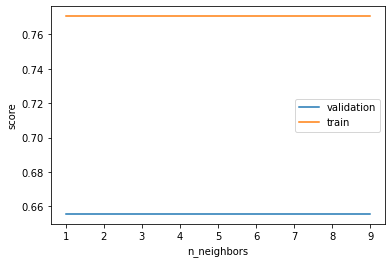

In [28]:
from sklearn.model_selection import validation_curve
k = np.arange(1, 10)

train_score, val_score = validation_curve(log_reg, X_train, y_train, cv=3,param_name='random_state', param_range=k)

plt.plot(k, val_score.mean(axis=1), label='validation')
plt.plot(k, train_score.mean(axis=1), label='train')

plt.ylabel('score')
plt.xlabel('n_neighbors')
plt.legend()

In [ ]:
tokens = "grise".split()

new_vector =dm_model.infer_vector(tokens)
sims = dm_model.dv.most_similar([new_vector])

In [ ]:
sims